#### Combine right and left hemispheres in mega matrix to rule them all

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import seaborn as sns
import matplotlib.font_manager

In [2]:
import sys
utils_dir = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/streams/utils/'
sys.path.append(utils_dir)
from rsm_utils import get_flat_lower_tri, make_flat_rsms

In [3]:
def get_lower_tri(x, with_diagonal=False):
    """
    Returns the lower triangle of a provided matrix
    Inputs
        x (np.ndarray): 2D matrix to get triangle from
        with_diagonal (bool): if True, keeps the diagonal as part of lower triangle
    """
    k = 0 if with_diagonal else -1
    return x[np.tril_indices_from(x, k=k)]

In [4]:
## Set plotting params
sns.set(rc={
             'axes.axisbelow': False,
             'axes.edgecolor': 'lightgrey',
             'axes.facecolor': 'None',
             'axes.grid': False,
             'axes.spines.right': False,
             'axes.spines.top': False,
             'figure.facecolor': 'white',
             'patch.edgecolor': 'w',
             'xtick.bottom': False,
             'xtick.direction': 'out',
             'xtick.top': False,
             'ytick.direction': 'out',
             'ytick.left': False,
             'ytick.right': False,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16})

In [5]:
data_dir = '../../../data/'
local_data_dir = '../../../local_data/'

subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

#threshold for voxels (based on split-half reliability)
thresh = .2

hemis = ['lh', 'rh']

In [6]:
both_flat_rsm = []

for hidx, hemi in enumerate(hemis):
    
    flat_rsm = make_flat_rsms(subjid, ROI_names, hemi, thresh)    
    both_flat_rsm.append(flat_rsm)  

In [7]:
r1_trial_order = [0, 0, 0, 1, 1, 1, 2, 2, 2]
r2_trial_order = [0, 1, 2, 0, 1, 2, 0, 1, 2]

#don't use same trials when same subject
ss_r1_trial_order = [0, 0, 1, 1, 2, 2]
ss_r2_trial_order = [1, 2, 0, 2, 0, 1]

In [8]:
total_combs = len(subjid) * (len(ROI_names)-1) * len(hemis)
total_combs/2

56.0

In [9]:
total_combs = len(subjid) * (len(ROI_names)-1) * len(hemis)
mega_matrix = np.zeros((total_combs,total_combs))

for i in range(total_combs): #rows - i.e. model candidate
    
    #take into account repeat of rois & subjects for 2 hemis
    if i < total_combs/2:
        idx = i
    else:
        idx = i - total_combs/2
    
    roi_idx1 = int(idx//8) #roi
    sidx1 = int(idx%8) #subject
    if i < total_combs/2:
        hidx1 = 0 #left hemi
    else:
        hidx1 = 1 #right hemi
    
    split_half = np.zeros((3))
    split_half = [stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,0],both_flat_rsm[hidx1][sidx1,roi_idx1,:,1])[0],
                  stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,0],both_flat_rsm[hidx1][sidx1,roi_idx1,:,2])[0],
                  stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,1],both_flat_rsm[hidx1][sidx1,roi_idx1,:,2])[0]]
    NC_model = np.mean(split_half) * 100
    
    for j in range(total_combs): #columns - i.e. target data
        
        #take into account repeat of rois & subjects for 2 hemis
        if j < total_combs/2:
            jdx = j
        else:
            jdx = j - total_combs/2
            
        roi_idx2 = int(jdx//8) #roi
        sidx2 = int(jdx%8) #subject
        if j < total_combs/2:
            hidx2 = 0 #left hemi
        else:
            hidx2 = 1 #right hemi
            
        split_half = np.zeros((3))
        split_half = [stats.pearsonr(both_flat_rsm[hidx2][sidx2,roi_idx2,:,0],both_flat_rsm[hidx2][sidx2,roi_idx2,:,1])[0],
                      stats.pearsonr(both_flat_rsm[hidx2][sidx2,roi_idx2,:,0],both_flat_rsm[hidx2][sidx2,roi_idx2,:,2])[0],
                      stats.pearsonr(both_flat_rsm[hidx2][sidx2,roi_idx2,:,1],both_flat_rsm[hidx2][sidx2,roi_idx2,:,2])[0]]
        NC_target = np.mean(split_half) * 100
        
        if (sidx1 == sidx2): #within subject
            rsm_corr = np.zeros((6))
            for r in range(6):
                rsm_corr[r] = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,ss_r1_trial_order[r]],
                                             both_flat_rsm[hidx2][sidx2,roi_idx2,:,ss_r2_trial_order[r]])[0]
            mega_matrix[i,j] = np.mean(rsm_corr) #* np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
        else: #between subject
            rsm_corr = np.zeros((9))
            for r in range(9):
                rsm_corr[r] = stats.pearsonr(both_flat_rsm[hidx1][sidx1,roi_idx1,:,r1_trial_order[r]],
                                             both_flat_rsm[hidx2][sidx2,roi_idx2,:,r2_trial_order[r]])[0]
            mega_matrix[i,j] = np.mean(rsm_corr) #* np.sqrt(100/NC_model) * np.sqrt(100/NC_target)

In [8]:
#save to local data folder
save_file = local_data_dir + 'processed/mega_mega_matrix_no_correction.data'

with open(save_file, 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump([mega_matrix], filehandle)


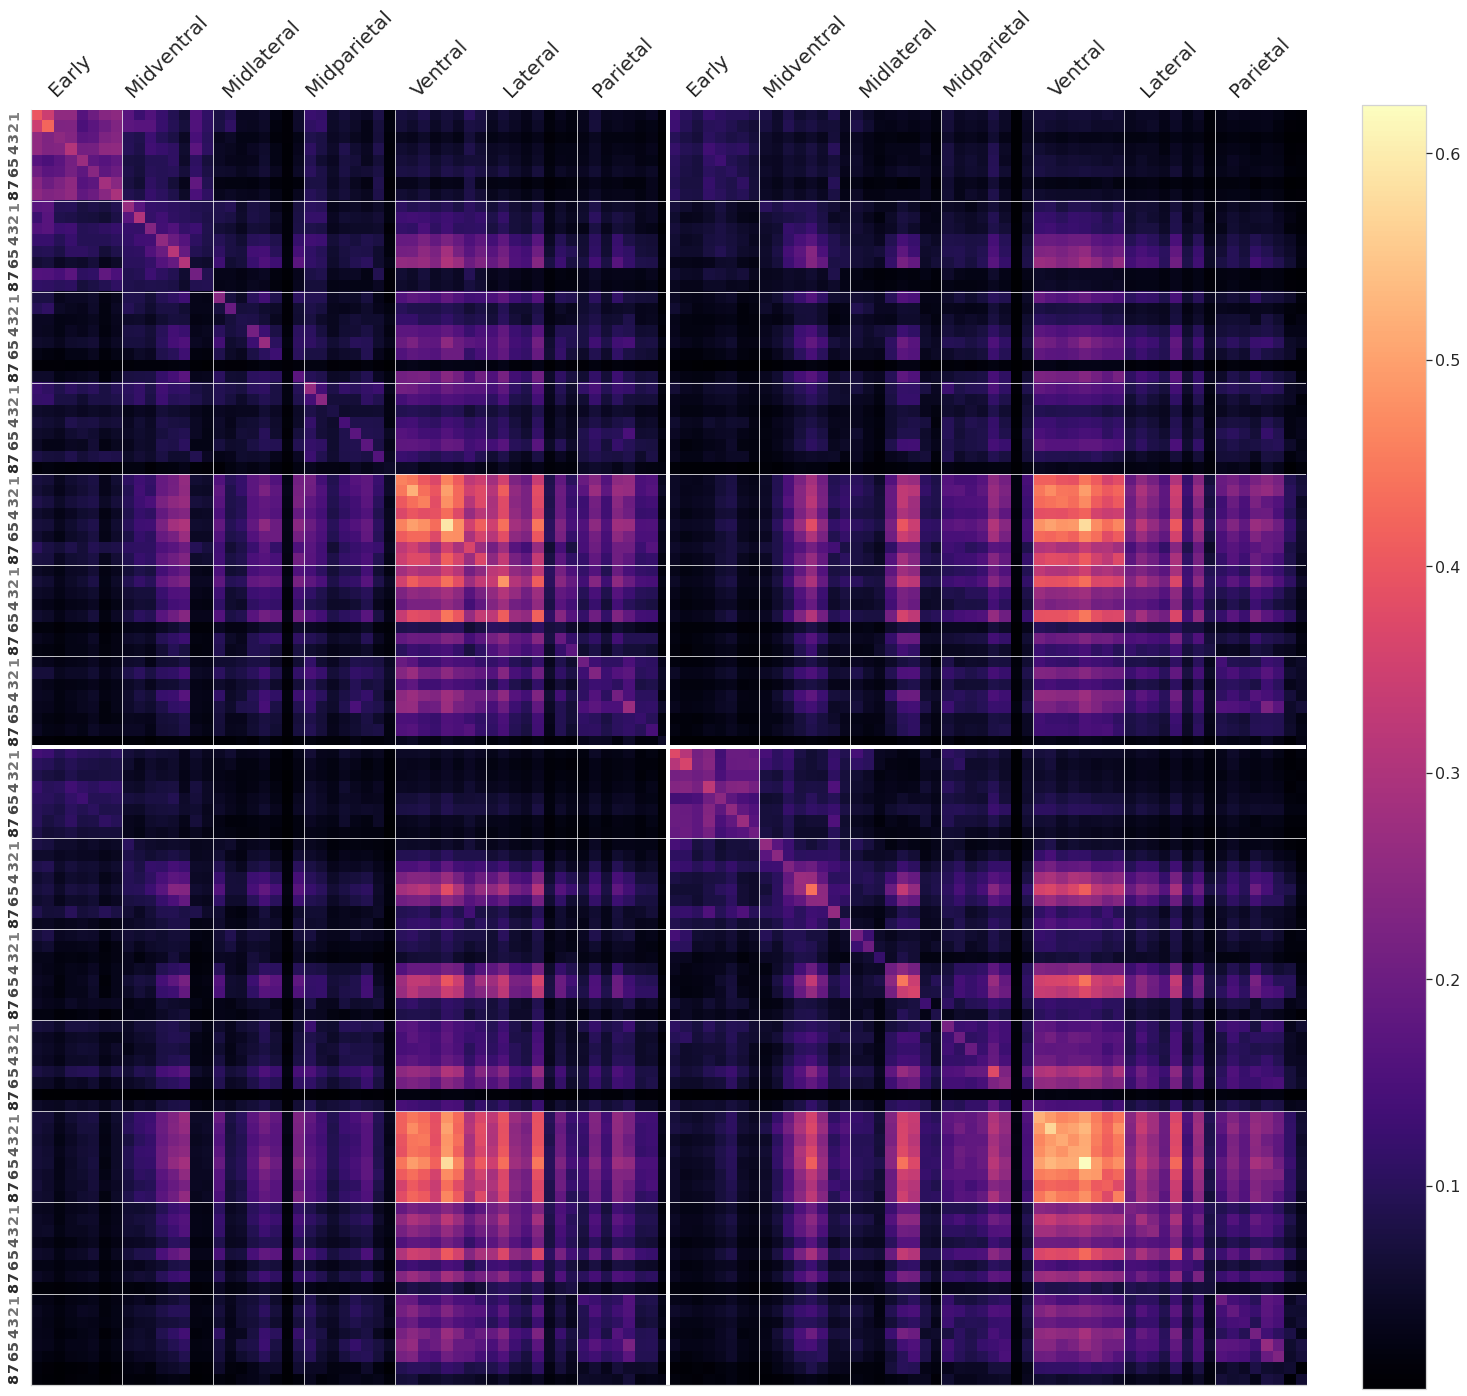

In [11]:
plt.figure(figsize=(25, 25))
plt.imshow(mega_matrix,
           cmap='magma')

y_labels = ['1', '2', '3', '4', '5', '6', '7', '8']
x_labels = ['Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal',
            'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

xlocs = np.array([3,11.5,19.75,27.5,35.5,43.5,51.5])
x_ticks= np.concatenate((xlocs,xlocs+56))
plt.xticks(x_ticks, x_labels, fontsize=20, rotation = 45)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, total_combs)
plt.yticks(y_ticks, np.tile(y_labels, 2*7), fontsize='large', fontweight='extra bold', rotation = 90)
colors = ['#808080','#737373','#666666','#595959','#4d4d4d','#404040','#333333','#262626','#1a1a1a','#0d0d0d','#000000']
##66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000','#000000']
for i in range(total_combs):
    r = i%8
    plt.gca().get_yticklabels()[i].set_color(colors[r])

for l in range(13):
    if l == 6:
        plt.axvline(x=7.5 + l*8, c='w',linewidth=4)
        plt.axhline(y=7.5 + l*8, c='w',linewidth=4)
    else:
        plt.axvline(x=7.5 + l*8, c='w',linewidth=0.75)
        plt.axhline(y=7.5 + l*8, c='w',linewidth=0.75)

#plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_no_correction_wholebrain.png')
plt.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_no_correction_wholebrain.svg')


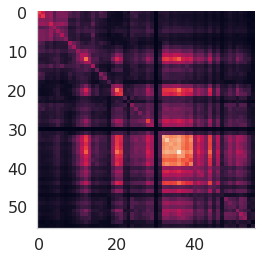

In [23]:
right = mega_matrix[int(112/2):, int(112/2):]
left = mega_matrix[:int(112/2), :int(112/2)]

plt.imshow(right)

In [39]:
tril_idx = np.tril_indices_from(right, k=-1)

indiv_total_combs = len(subjid) * (len(ROI_names)-1)

within_roi_right = [[] for j in range(len(ROI_names)-1)]
for i in range(indiv_total_combs): #rows - i.e. model candidate
    roi_idx1 = i//8 #roi
    sidx1 = i%8 #subject
    
    for j in range(indiv_total_combs): #columns - i.e. target data
        roi_idx2 = j//8 #roi
        sidx2 = j%8 #subject
        
        if (i,j) in list(zip(tril_idx[0],tril_idx[1])): #check that we're in lower triangle
            
            for r in range(len(ROI_names)-1):
                if (roi_idx1 == r and roi_idx2 == r):
                    within_roi_right[r].append(right[i,j])

within_roi_left = [[] for j in range(len(ROI_names)-1)]
for i in range(indiv_total_combs): #rows - i.e. model candidate
    roi_idx1 = i//8 #roi
    sidx1 = i%8 #subject
    
    for j in range(indiv_total_combs): #columns - i.e. target data
        roi_idx2 = j//8 #roi
        sidx2 = j%8 #subject
        
        if (i,j) in list(zip(tril_idx[0],tril_idx[1])): #check that we're in lower triangle
            
            for r in range(len(ROI_names)-1):
                if (roi_idx1 == r and roi_idx2 == r):
                    within_roi_left[r].append(left[i,j])

In [40]:
np.mean(within_roi_right[4])

0.46118518333006586

In [41]:
diag_right = np.diagonal(right)
vent_diag_right = diag[8*4:8*5]

diag_left = np.diagonal(left)
vent_diag_left = diag[8*4:8*5]

In [37]:
data_r = [np.mean(within_roi[4]), np.mean(vent_diag)]
data_r

[0.46118518333006586, 0.5129909491108356]

In [71]:
np.mean(within_roi_left[4])

0.3850237323392825

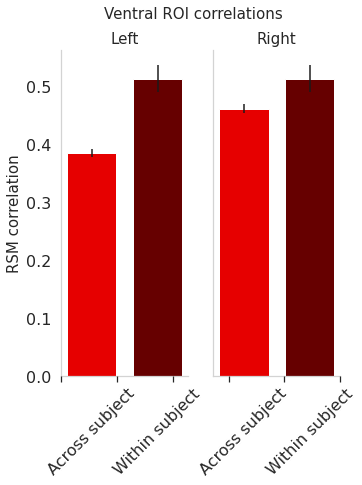

In [70]:
import matplotlib.colors as mcolors

data_r = [np.mean(within_roi_right[4]), np.mean(vent_diag_right)]
error_r = [stats.sem(within_roi_right[4]), stats.sem(vent_diag_right)]

data_l = [np.mean(within_roi_left[4]), np.mean(vent_diag_left)]
error_l = [stats.sem(within_roi_left[4]), stats.sem(vent_diag_left)]

fig, axs = plt.subplots(1, 2,figsize=(5,6), sharey=True)

clist = [(0, "black"), (0.5, "red")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)


width = 0.75
xlocations = np.array(range(len(data_l)))+.1

axs[0].bar(np.array(range(len(data_l)))+.1, data_l, 
        yerr=error_r, width=width, color=['#e60000', '#660000'])
axs[0].set_title("Left", fontsize = 15)


plt.sca(axs[0])
plt.xticks(xlocations, ['Across subject', 'Within subject'], rotation=45)

axs[1].bar(np.array(range(len(data_r)))+.1, data_r, 
        yerr=error_r, color=['#e60000', '#660000'], width=width)
axs[1].set_title("Right", fontsize = 15)
axs[1].xaxis.get_label().set_fontsize(20)


plt.sca(axs[1])
plt.xticks(np.array(range(len(data_l)))+.1,  ['Across subject', 'Within subject'], rotation=45)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.ylabel("RSM correlation", fontsize = 15)

#plt.gca().get_yaxis().tick_left()
plt.gca().get_xaxis().tick_bottom()

plt.ylim(0,1)
fig.suptitle("Ventral ROI correlations ", fontsize = 15)

#plt.show()

plt.savefig('../../../results/figures/ventral_correlations.png')


In [13]:
mega_MDS = MDS(dissimilarity='precomputed')
x, y = mega_MDS.fit_transform(1-mega_matrix).T

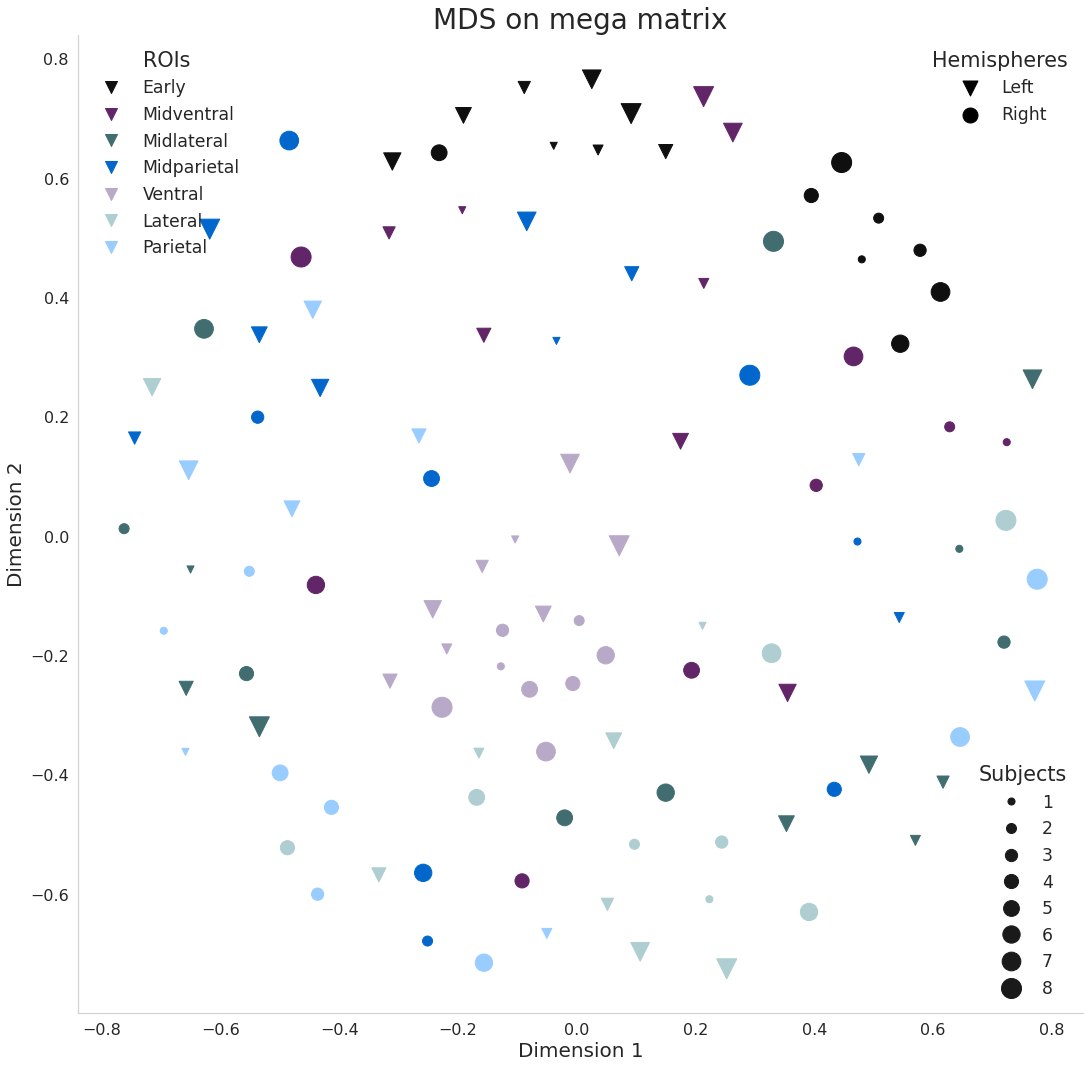

In [15]:
lh_x = x[0:int(len(x)/2)]
lh_y = y[0:int(len(x)/2)]

rh_x = x[int(len(x)/2):]
rh_y = y[int(len(x)/2):]

fig, ax = plt.subplots(figsize=(18, 18))

s = 50*np.array([[1,2,3,4,5,6,7,8]])
sizes = np.tile(s, 7)

c = np.array([[1,2,3,4,5,6,7]])
colors = np.repeat(c, 8)

rois =('Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal')

presets = ['#0f0f0f' , '#622569', '#416d71', '#0066cc', '#b8a9c9' ,'#aeced0', '#99ccff']
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("my_colormap",presets)

scatter = ax.scatter(lh_x, lh_y, s=sizes, c=colors, cmap=cmap, marker = "v") 
scatter2 = ax.scatter(rh_x, rh_y, s=sizes, c=colors, cmap=cmap) 

legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=rois, 
                     loc="upper left", title="ROIs", title_fontsize = 'xx-large', fontsize='x-large',
                     markerscale = 2, frameon=False)
ax.add_artist(legend1)

kw = dict(prop="sizes", num=8, color='k', fmt="{x:.0f}",
          func=lambda s: s/50)
legend2 = ax.legend(*scatter2.legend_elements(**kw),
                    loc="lower right", title="Subjects", title_fontsize = 'xx-large', 
                    fontsize='x-large', frameon=False)
ax.add_artist(legend2)

ax.legend(labels=['Left', 'Right'], title="Hemispheres", edgecolor = 'black',
          title_fontsize = 'xx-large', fontsize='x-large', frameon=False)
leg = ax.get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')

ax.set_title('MDS on mega matrix', fontsize = 28)
ax.set_xlabel("Dimension 1", fontsize=20)
ax.set_ylabel("Dimension 2", fontsize=20)

plt.show()

fig.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_no_correction_whole_MDS.png')

In [16]:
## Stress calcs (credit: https://stackoverflow.com/questions/36428205/stress-attribute-sklearn-manifold-mds-python)
data = 1-mega_matrix

# Coordinates of points in the plan (n_components=2)
points = mega_MDS.embedding_

## sklearn Stress
print("sklearn stress :")
print(mega_MDS.stress_)
print("")

## Manual calculus of sklearn stress
DE = euclidean_distances(points)
stress = 0.5 * np.sum((DE - data)**2)
print("Manual calculus of sklearn stress :")
print(stress)
print("")

## Kruskal's stress (or stress formula 1)
stress1 = np.sqrt(stress / (0.5 * np.sum(data**2)))
print("Kruskal's Stress :")
print("[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0]")
print(stress1)
print("")

sklearn stress :
762.3238419109198

Manual calculus of sklearn stress :
762.2679589039392

Kruskal's Stress :
[Poor > 0.2 > Fair > 0.1 > Good > 0.05 > Excellent > 0.025 > Perfect > 0.0]
0.3848063745404015



In [21]:
regressor_indices = [
        np.hstack((np.repeat(1, 56), np.repeat(0, 56))), #hemisphere
        np.tile(np.tile(np.arange(8), 7),2),  # subjects
        np.tile(np.repeat(np.arange(7), 8),2),  # ROIs
        
    ]

regressors = []
view = []
for indices in regressor_indices:
    base = np.zeros((56*2, 56*2))
    xx, yy = np.meshgrid(indices, indices)
    base[xx == yy] = 1
    
    view.append(base)

    regressors.append(get_lower_tri(1 - base, with_diagonal=False))

Text(0.5, 1.0, 'ROI')

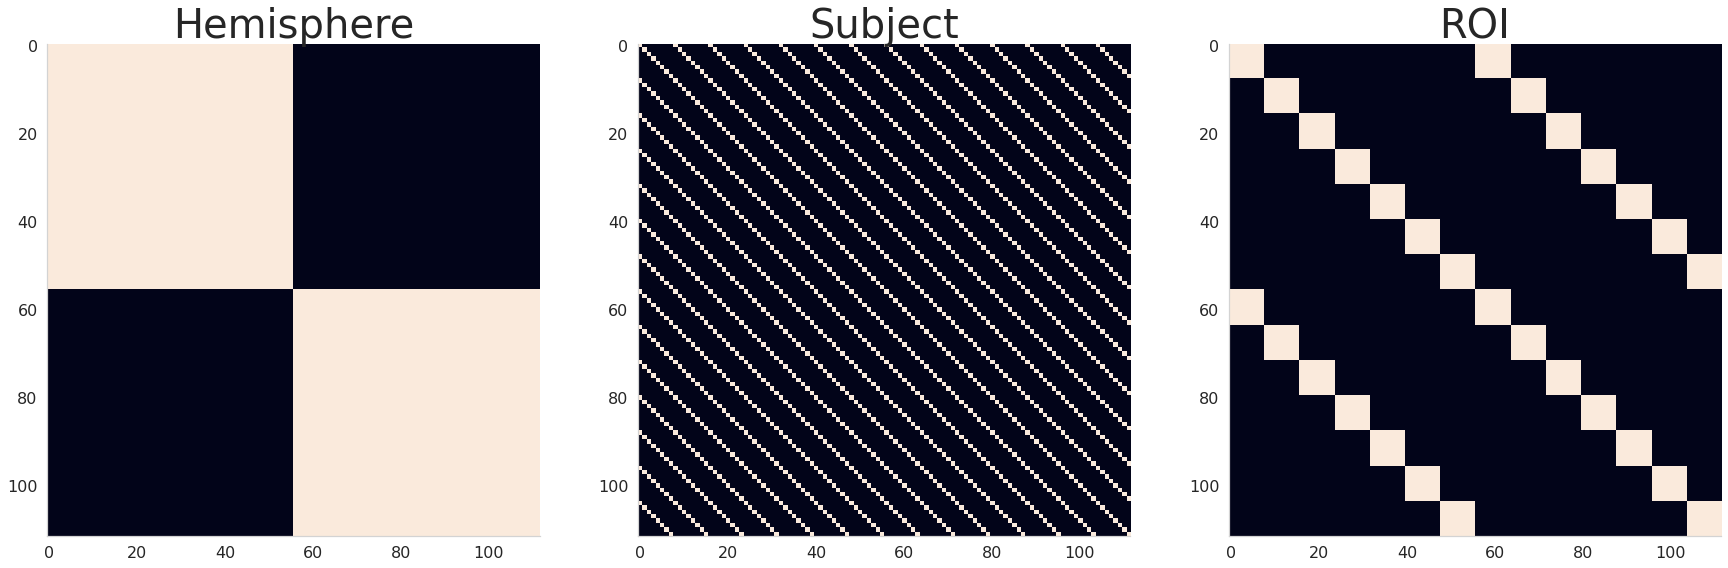

In [24]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3,figsize=(30,10))

ax0.imshow(view[0])
ax0.set_title('Hemisphere', fontsize=40)
ax1.imshow(view[1])
ax1.set_title('Subject', fontsize=40)
ax2.imshow(view[2])
ax2.set_title('ROI', fontsize=40)

In [26]:
mega_mega_RDM = get_lower_tri(1 - mega_matrix, with_diagonal=False)

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

X = np.array([x.flatten() for x in regressors]).T
y = mega_mega_RDM

In [28]:
reg = LinearRegression().fit(X, y)

In [29]:
reg.coef_

array([0.01532122, 0.01090234, 0.06657258])

In [30]:
X2 = sm.add_constant(X) #fit intercept

est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     177.9
Date:                Tue, 12 Jan 2021   Prob (F-statistic):          1.10e-110
Time:                        10:24:57   Log-Likelihood:                 6770.0
No. Observations:                6216   AIC:                        -1.353e+04
Df Residuals:                    6212   BIC:                        -1.350e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8283      0.004    193.521      0.0